# **Convolutional Neural Network (CNN)**


## Objective

1. Implement **Convolutional Neural Network(CNN)** using pytorch
2. Comparision between **Multi-Layer Perceptron (MLP)** and **CNN**



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

##**1.Convolutional Neural Network(CNN)**


- Convolutional layer can be defined by `torch.nn.Conv2d`
- Convolutional layer needs different arguments from fully connected layer(nn.Linear)
  - FC layer needs **size of input feature** and **size of output feature** for arguments
  - Convolutional layer needs **a number of input channel** and **a number of output channel** similarly, but also it needs **size of kernel (filter)**
- Convolutional layer utilizes different weight from FC layer
  - FC layer utilizes weight size of 2-dimentional matrix (*output feature size, input feature size*)
  - Convolutional layer utilizes weight size of  4-dimentional tensor (*output channel size, input channel size, kernel height, kernel width*)


In [2]:
linear_layer = nn.Linear(in_features=784, out_features=400)
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5))
print("Shape of Linear layer weight:" ,end=" ")
print(linear_layer.weight.shape)
print("Shape of Convolutional layer weight:", end=" ")
print(convolutional_layer.weight.shape)

Shape of Linear layer weight: torch.Size([400, 784])
Shape of Convolutional layer weight: torch.Size([32, 3, 5, 5])


Loading MNIST dataset using a package `torchvision`

In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 294470572.88it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29538086.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 130309034.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6555584.57it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



These are functions for visualizing features of CNN. You don't have to look in detail.

In [4]:
def vis_feat(f1, f2, inp):
  l = [f1, f2]
  fig, axes = plt.subplots(11, 8, figsize=(12.5,12.5))
  plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace=0, hspace=0.1)
  ax = axes[0,0]
  ax.imshow(inp[0], cmap='gray_r')
  ax.set_title('Original image')
  ax.axis('off')

  for i in range(7):
    ax = axes[0,i+1]
    ax.axis('off')

  for i in range(32):
      r = 2 + i // 8
      c = i % 8
      ax = axes[r, c]
      ax.imshow(f1[i], cmap='gray_r')
      if i == 0:
        ax.set_title('Output from conv1')
      ax.axis('off')
      if i < 8:
        ax = axes[1, i]
        ax.axis('off')

  for i in range(32):
    r = 7 + i // 8
    c = i % 8
    ax = axes[r, c]
    ax.imshow(f2[i], cmap='gray_r')
    if i == 0:
      ax.set_title('Output from conv2')
    ax.axis('off')
    if i < 8:
        ax = axes[6, i]
        ax.axis('off')

  plt.xticks([]), plt.yticks([])
  plt.show()

In [5]:
def vis(model, loader):
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, labels = data
      f1 = model.conv1(images)
      f2 = model.conv2(model.pool(F.relu(f1)))

      vis_feat(f1[0], f2[0], images[0])
      break

### **1.1. Implement of CNN using pytorch**


Construct convolutional neural network below using `torch.nn.Conv2d`, `torch.nn.MaxPool2d`, and `torch.nn.Linear`

* **Architecture 1**
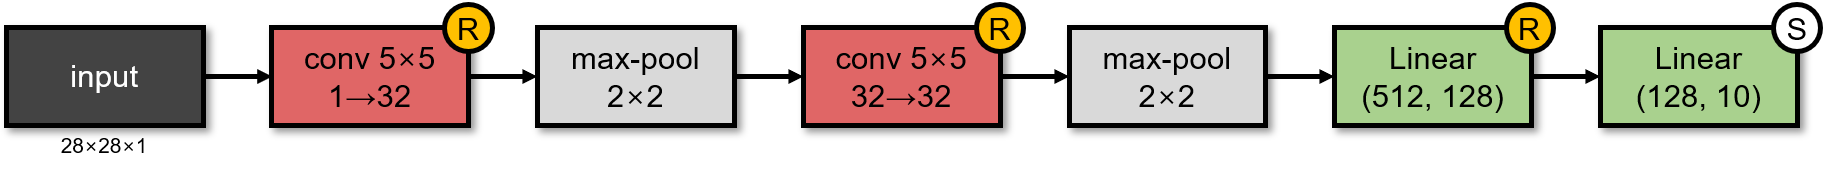

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Construct convolutional layer
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5))
    # num of input channel = 1, num of output channel 32, kernel size = 5×5
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    # num of input channel = 1, num of output channel 32, kernel size = 5×5 (5 = 5×5)

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.conv1(x) # output for feature visuallization
    x = self.pool(F.relu(x)) # Convolutional layer -> ReLU activation -> max_pooling
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.fc1(x))
    out = self.fc2(x)
    return out

Define a function `train` for train the model and `evaluate` for test the model and measure its accuracy

In [7]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(input=outputs, target=labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
  print('Training Finished')


In [8]:
def evaluate(model, loader, device="cpu"):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  acc = 100*correct/total
  return acc

Train the model using a function `train`

When we use only CPU, it takes long time due to tremendous computation of convolutional layer.

You can see how much it takes for one epoch for example.

In [9]:
cnn_model = CNN()
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion)

100%|██████████| 1/1 [00:16<00:00, 16.28s/it]

Epoch 0, loss = 2.244
Training Finished


As you can see, it takes really long for just one epoch.

Rather than using CPU, let's try other way.

Train and test the model using functions `train` and `evaluate`

You can reduce training time using GPU that works as neural network accelarator.

- CNN shares parameters of the kernal, so you can accelarate the network with powerful parallel computing of GPU.

In [10]:
cnn_model = CNN().to("cuda")
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))


  7%|▋         | 1/15 [00:13<03:06, 13.32s/it]

Epoch 0, loss = 2.222


 13%|█▎        | 2/15 [00:20<02:04,  9.59s/it]

Epoch 1, loss = 1.085


 20%|██        | 3/15 [00:27<01:39,  8.32s/it]

Epoch 2, loss = 0.440


 27%|██▋       | 4/15 [00:33<01:24,  7.73s/it]

Epoch 3, loss = 0.340


 33%|███▎      | 5/15 [00:40<01:14,  7.42s/it]

Epoch 4, loss = 0.286


 40%|████      | 6/15 [00:47<01:04,  7.22s/it]

Epoch 5, loss = 0.246


 47%|████▋     | 7/15 [00:54<00:57,  7.15s/it]

Epoch 6, loss = 0.215


 53%|█████▎    | 8/15 [01:01<00:49,  7.05s/it]

Epoch 7, loss = 0.191


 60%|██████    | 9/15 [01:08<00:41,  6.99s/it]

Epoch 8, loss = 0.168


 67%|██████▋   | 10/15 [01:15<00:34,  6.96s/it]

Epoch 9, loss = 0.150


 73%|███████▎  | 11/15 [01:22<00:27,  6.91s/it]

Epoch 10, loss = 0.137


 80%|████████  | 12/15 [01:28<00:20,  6.90s/it]

Epoch 11, loss = 0.125


 87%|████████▋ | 13/15 [01:35<00:13,  6.88s/it]

Epoch 12, loss = 0.116


 93%|█████████▎| 14/15 [01:42<00:06,  6.89s/it]

Epoch 13, loss = 0.107


100%|██████████| 15/15 [01:49<00:00,  7.30s/it]

Epoch 14, loss = 0.101
Training Finished


Test accuracy: 97.40%


Now, let's see the visualization of features of CNN we trained.

You can run it several times to see different images each time.

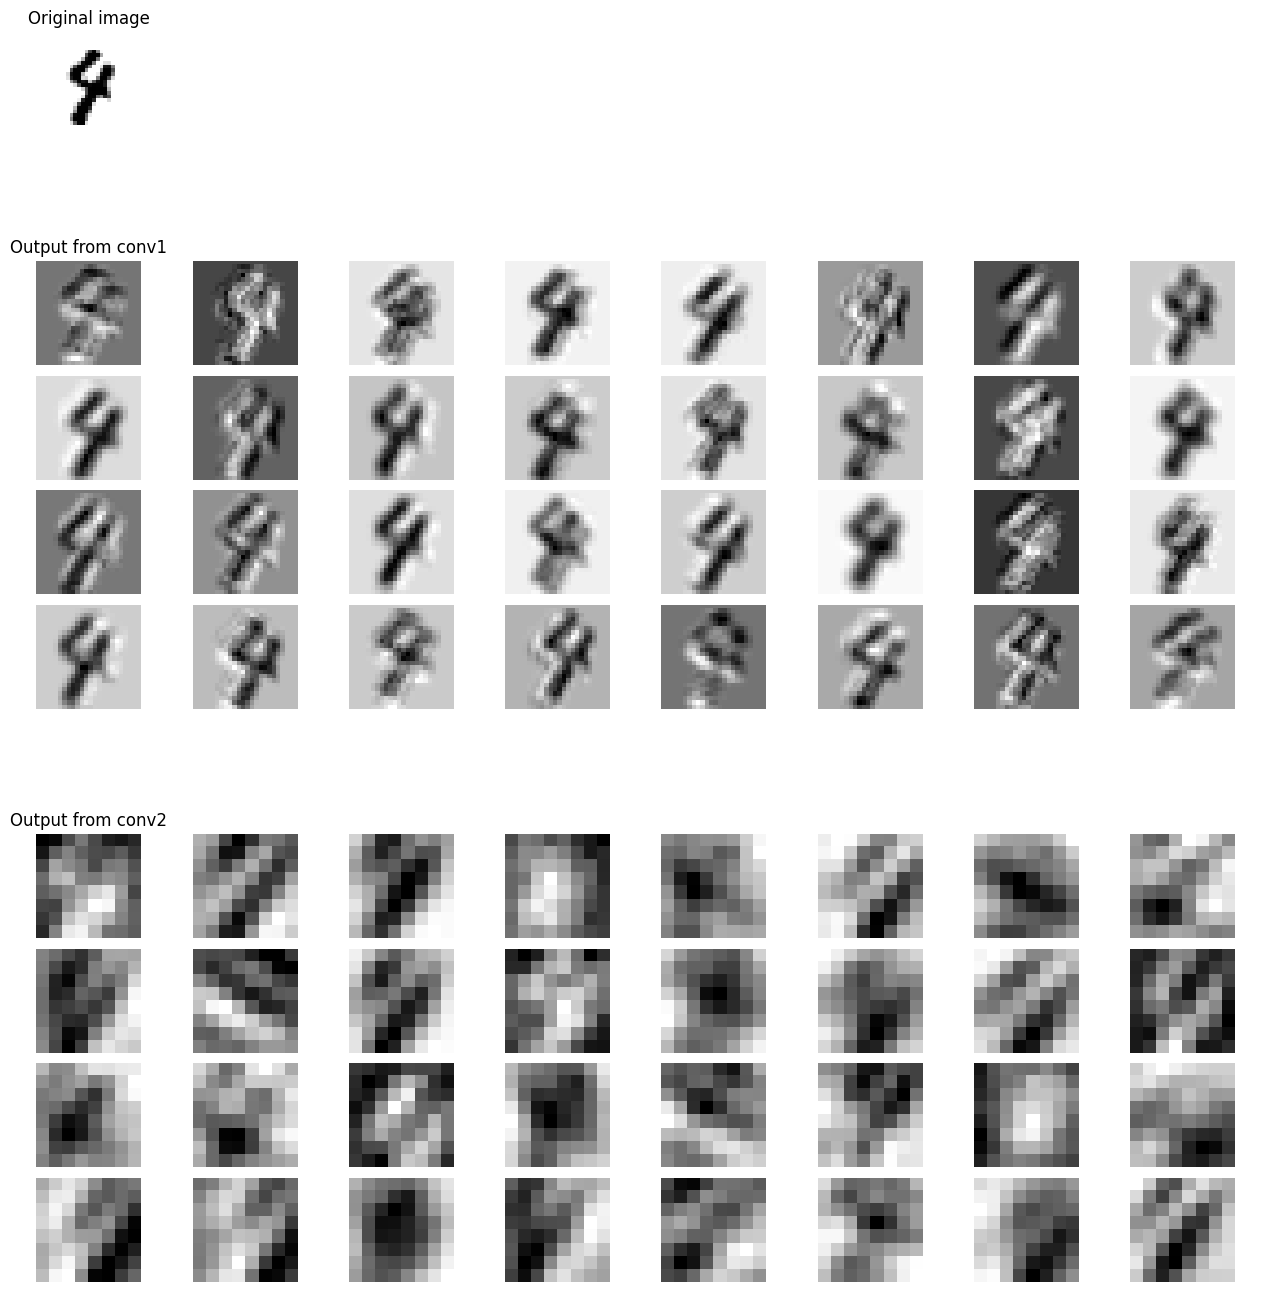

In [11]:
vis(cnn_model.cpu(), trainloader)

### **1.2.Comparison between CNN and Multi-Layer Perceptron (MLP)**

Compare CNN with MLP
  - CNN needs more number of computations and also longer training time
  - CNN has fewer parameters
  - CNN shows higher performance in image processing task

Construct MLP using `torch.nn.Linear`

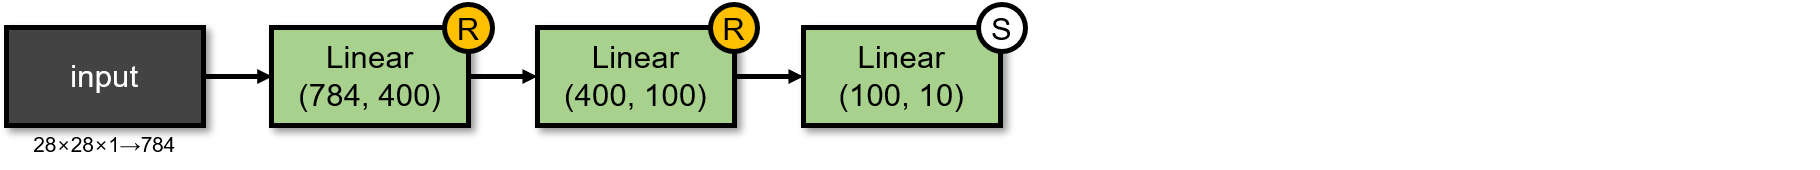

In [12]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=400)
    self.layer2 = nn.Linear(in_features=400, out_features=100)
    self.layer3 = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    batchsize = x.size(0)
    x = x.view(batchsize, -1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    out = self.layer3(x)
    return out

Train and Test the model using functions `train` and `evaluate`

  - Check training time and performance(accuracry) and compare with CNN

In [13]:
mlp_model = MLP().to("cuda")
optimizer = optim.SGD(params=mlp_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=mlp_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(mlp_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:05<01:23,  5.98s/it]

Epoch 0, loss = 2.246


 13%|█▎        | 2/15 [00:12<01:18,  6.03s/it]

Epoch 1, loss = 1.900


 20%|██        | 3/15 [00:18<01:12,  6.05s/it]

Epoch 2, loss = 1.139


 27%|██▋       | 4/15 [00:24<01:06,  6.04s/it]

Epoch 3, loss = 0.718


 33%|███▎      | 5/15 [00:30<00:59,  6.00s/it]

Epoch 4, loss = 0.554


 40%|████      | 6/15 [00:36<00:54,  6.04s/it]

Epoch 5, loss = 0.472


 47%|████▋     | 7/15 [00:42<00:48,  6.03s/it]

Epoch 6, loss = 0.424


 53%|█████▎    | 8/15 [00:48<00:42,  6.03s/it]

Epoch 7, loss = 0.394


 60%|██████    | 9/15 [00:54<00:36,  6.02s/it]

Epoch 8, loss = 0.373


 67%|██████▋   | 10/15 [01:00<00:30,  6.02s/it]

Epoch 9, loss = 0.357


 73%|███████▎  | 11/15 [01:06<00:24,  6.04s/it]

Epoch 10, loss = 0.344


 80%|████████  | 12/15 [01:12<00:18,  6.07s/it]

Epoch 11, loss = 0.333


 87%|████████▋ | 13/15 [01:18<00:12,  6.04s/it]

Epoch 12, loss = 0.323


 93%|█████████▎| 14/15 [01:24<00:06,  6.06s/it]

Epoch 13, loss = 0.314


100%|██████████| 15/15 [01:30<00:00,  6.04s/it]

Epoch 14, loss = 0.307
Training Finished


Test accuracy: 91.64%


Compare the number of parameters between CNN and MLP
  - Check which model has more parameters

In [14]:
mlp_num_parameters = sum(param.numel() for param in mlp_model.parameters() if param.requires_grad)
mlp_acc = evaluate(mlp_model, testloader, device="cuda")
print('Total Number of trainable parameters of MLP: {}, Accuracy of MLP: {:.2f}%'.format(mlp_num_parameters, mlp_acc))

cnn_model = cnn_model.to("cuda")
cnn_num_parameters = sum(param.numel() for param in cnn_model.parameters() if param.requires_grad)
cnn_acc = evaluate(cnn_model, testloader, device="cuda")
print('Total Number of trainable parameters of CNN: {}, Accuracy of CNN: {:.2f}%'.format(cnn_num_parameters, cnn_acc))

Total Number of trainable parameters of MLP: 355110, Accuracy of MLP: 91.64%
Total Number of trainable parameters of CNN: 93418, Accuracy of CNN: 97.40%


###**Task 1: Construct CNN by yourself**

* **Architecture 2**
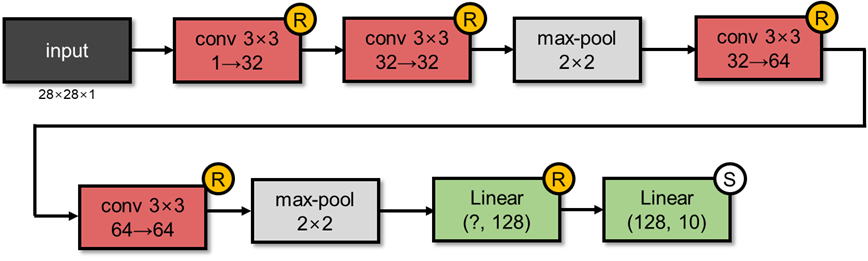

In [15]:
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2, self).__init__()
    # Construct convolutional layer
    ############# ENTER YOUR CODE HERE #################
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)


    self.fc1 = nn.Linear(in_features=1024, out_features=128)
    #####################################################

    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    ############## ENTER YOUR CODE HERE ##############
    batchsize = x.size(0)
    x = self.conv1(x) # output for feature visuallization
    x = self.conv2(F.relu(x))
    x = self.pool(F.relu(x))
    x = self.conv3(x)
    x = self.conv4(F.relu(x))
    x = self.pool(F.relu(x))
    x = x.view(batchsize,-1)
    x = F.relu(self.fc1(x))
    ################################################

    out = self.fc2(x)
    return out

Now, Let's see if you've done well.

In [16]:
cnn_model2 = CNN2().to("cuda")
optimizer = optim.SGD(params=cnn_model2.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model2, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model2, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:08<02:01,  8.70s/it]

Epoch 0, loss = 2.301


 13%|█▎        | 2/15 [00:17<01:53,  8.73s/it]

Epoch 1, loss = 2.281


 20%|██        | 3/15 [00:26<01:45,  8.76s/it]

Epoch 2, loss = 1.305


 27%|██▋       | 4/15 [00:34<01:36,  8.74s/it]

Epoch 3, loss = 0.404


 33%|███▎      | 5/15 [00:43<01:27,  8.76s/it]

Epoch 4, loss = 0.276


 40%|████      | 6/15 [00:52<01:18,  8.74s/it]

Epoch 5, loss = 0.199


 47%|████▋     | 7/15 [01:01<01:09,  8.74s/it]

Epoch 6, loss = 0.151


 53%|█████▎    | 8/15 [01:10<01:01,  8.78s/it]

Epoch 7, loss = 0.124


 60%|██████    | 9/15 [01:18<00:52,  8.80s/it]

Epoch 8, loss = 0.110


 67%|██████▋   | 10/15 [01:27<00:44,  8.82s/it]

Epoch 9, loss = 0.097


 73%|███████▎  | 11/15 [01:36<00:35,  8.79s/it]

Epoch 10, loss = 0.087


 80%|████████  | 12/15 [01:45<00:26,  8.79s/it]

Epoch 11, loss = 0.080


 87%|████████▋ | 13/15 [01:54<00:17,  8.78s/it]

Epoch 12, loss = 0.073


 93%|█████████▎| 14/15 [02:02<00:08,  8.76s/it]

Epoch 13, loss = 0.069


100%|██████████| 15/15 [02:11<00:00,  8.76s/it]

Epoch 14, loss = 0.063
Training Finished


Test accuracy: 98.08%


##**Task 2: Improving CNN using batch-normalization**

- CNN can be stabilized by batch normailization just like MLP
- Batch normalization layer is usually applied between convolutional layer and activation function (Relu)


**Based on Architecture 1**, try to create the cnn model with batch normalization layer.

You should use `nn.Batchnorm2d(# of channel)` for CNN because the output of CNN is 2D×(# of channel)

In [17]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN, self).__init__()
    # Fill in the blank
    ##################################################
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5))
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max-pooling with kernel size = 2×2, stride = 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(32)

    #####################################################

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(in_features=128, out_features=10) # The output size of last FC layer must be equal to num of class

  def forward(self, x):
    batchsize = x.size(0)
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Convolutional layer -> BN -> ReLU activation -> max_pooling
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(batchsize,-1) # Change the shape of output from [batch_size, channels, height, width] to [batch_size, channels*height*width]
    x = F.relu(self.bn3(self.fc1(x)))
    out = self.fc2(x)
    return out

In [18]:
cnn_bn_model = CNN_BN().to("cuda")
optimizer = optim.SGD(params=cnn_bn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_bn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_bn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:07<01:42,  7.31s/it]

Epoch 0, loss = 0.672


 13%|█▎        | 2/15 [00:14<01:31,  7.06s/it]

Epoch 1, loss = 0.202


 20%|██        | 3/15 [00:21<01:24,  7.00s/it]

Epoch 2, loss = 0.132


 27%|██▋       | 4/15 [00:28<01:16,  6.99s/it]

Epoch 3, loss = 0.101


 33%|███▎      | 5/15 [00:35<01:09,  6.96s/it]

Epoch 4, loss = 0.083


 40%|████      | 6/15 [00:41<01:02,  6.96s/it]

Epoch 5, loss = 0.071


 47%|████▋     | 7/15 [00:48<00:55,  6.94s/it]

Epoch 6, loss = 0.063


 53%|█████▎    | 8/15 [00:55<00:48,  6.96s/it]

Epoch 7, loss = 0.056


 60%|██████    | 9/15 [01:02<00:41,  7.00s/it]

Epoch 8, loss = 0.050


 67%|██████▋   | 10/15 [01:09<00:35,  7.00s/it]

Epoch 9, loss = 0.046


 73%|███████▎  | 11/15 [01:16<00:27,  6.97s/it]

Epoch 10, loss = 0.042


 80%|████████  | 12/15 [01:23<00:20,  6.98s/it]

Epoch 11, loss = 0.039


 87%|████████▋ | 13/15 [01:30<00:13,  6.96s/it]

Epoch 12, loss = 0.036


 93%|█████████▎| 14/15 [01:37<00:06,  6.96s/it]

Epoch 13, loss = 0.034


100%|██████████| 15/15 [01:44<00:00,  6.99s/it]

Epoch 14, loss = 0.032
Training Finished


Test accuracy: 99.07%


In [21]:
train(model=cnn_bn_model, n_epoch=10, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")

 10%|█         | 1/10 [00:06<01:02,  6.99s/it]

Epoch 0, loss = 0.030


 20%|██        | 2/10 [00:13<00:55,  6.94s/it]

Epoch 1, loss = 0.028


 30%|███       | 3/10 [00:20<00:48,  6.94s/it]

Epoch 2, loss = 0.026


 40%|████      | 4/10 [00:27<00:41,  6.94s/it]

Epoch 3, loss = 0.025


 50%|█████     | 5/10 [00:34<00:34,  6.96s/it]

Epoch 4, loss = 0.024


 60%|██████    | 6/10 [00:41<00:27,  6.98s/it]

Epoch 5, loss = 0.023


 70%|███████   | 7/10 [00:48<00:20,  6.99s/it]

Epoch 6, loss = 0.021


 80%|████████  | 8/10 [00:55<00:13,  6.99s/it]

Epoch 7, loss = 0.020


 90%|█████████ | 9/10 [01:02<00:06,  6.98s/it]

Epoch 8, loss = 0.019


100%|██████████| 10/10 [01:09<00:00,  6.97s/it]

Epoch 9, loss = 0.018
Training Finished


In [29]:
model_copy = CNN_BN().to("cuda")

TypeError: ignored

In [30]:
for param in model_copy.parameters():
    print(param)

Parameter containing:
tensor([[[[ 1.5179e-01, -1.4757e-01, -7.1374e-02,  1.4858e-01, -1.4656e-03],
          [-1.2425e-02,  1.6827e-01, -1.0990e-01,  2.5574e-02,  1.9736e-01],
          [ 1.9874e-01,  9.9047e-02, -8.6589e-02,  1.4089e-01,  5.3127e-02],
          [ 5.3494e-02, -1.1639e-01, -1.9399e-01, -1.1412e-01, -5.3413e-02],
          [ 1.1261e-01,  1.0342e-03, -5.5195e-02, -6.7952e-02,  1.4469e-01]]],


        [[[ 1.0930e-01, -1.0362e-01, -4.2392e-02, -5.9670e-02,  1.2121e-01],
          [-1.1751e-01, -1.7356e-01,  1.3439e-01,  1.6941e-01,  1.0733e-01],
          [ 1.3191e-01,  1.7755e-01,  1.2458e-01, -1.1570e-01,  4.3391e-03],
          [-1.7286e-01,  5.5650e-02,  6.8611e-02, -7.1508e-02, -1.6094e-01],
          [-6.6840e-02, -7.8863e-02,  1.8015e-01,  7.1156e-02, -1.1841e-01]]],


        [[[-1.4005e-01, -1.9957e-01, -9.6700e-02,  1.5636e-01, -1.9179e-01],
          [-6.5148e-02,  5.4957e-02, -2.9979e-03, -1.5089e-01,  1.8217e-01],
          [ 1.0648e-01,  1.7741e-02,  8.6888e-

In [20]:
for name, param in cnn_bn_model.named_parameters():
    print('name:', name)

name: conv1.weight
name: conv1.bias
name: bn1.weight
name: bn1.bias
name: conv2.weight
name: conv2.bias
name: bn2.weight
name: bn2.bias
name: fc1.weight
name: fc1.bias
name: bn3.weight
name: bn3.bias
name: fc2.weight
name: fc2.bias


In [32]:
for param in cnn_model.parameters():
    print(param)

Parameter containing:
tensor([[[[-6.8534e-02,  1.1560e-02,  1.1195e-01, -2.0763e-01, -4.0612e-02],
          [-1.3057e-01, -1.2739e-01, -3.8396e-02,  2.5298e-02, -7.3848e-02],
          [ 7.5690e-03,  1.4540e-02, -1.5349e-01, -1.0160e-01, -1.4327e-01],
          [ 2.0353e-01,  1.0065e-01,  9.5656e-02,  1.5902e-01,  1.8987e-01],
          [-7.8846e-02,  1.5501e-02, -2.0050e-03,  2.2494e-01, -9.6595e-02]]],


        [[[-1.2840e-01,  9.5411e-02, -8.7454e-02,  1.5492e-01, -1.3959e-01],
          [ 4.8509e-02, -1.2868e-01,  1.7585e-01,  2.3633e-02, -1.5732e-01],
          [-1.7588e-01, -1.7696e-01, -1.0827e-02,  1.2971e-01,  1.2133e-01],
          [ 1.2731e-01, -1.9725e-01,  8.1995e-02, -7.1196e-02, -1.7454e-01],
          [-8.1276e-02, -1.2110e-01,  1.3707e-01, -1.7978e-02,  1.2704e-01]]],


        [[[ 2.2646e-01,  1.6538e-01,  1.4949e-01, -9.2438e-02, -4.1998e-02],
          [-2.7788e-02, -1.4180e-01,  1.8925e-01, -1.0359e-01, -2.7225e-02],
          [ 9.4009e-02, -9.1366e-02, -1.4803e-

In [ ]:
torch.save(cnn.model.state_dict(), 'path/to/save/weights.pth')

In [33]:
model2 = CNN().to("cuda")

In [34]:
for param in model2.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0916,  0.0899,  0.1450, -0.0046, -0.0106],
          [ 0.0300, -0.1045, -0.1428,  0.1984, -0.0819],
          [-0.1594,  0.1989, -0.0373,  0.1407, -0.0294],
          [ 0.1354,  0.0100,  0.1699, -0.0706,  0.1436],
          [-0.0501, -0.1109,  0.0361, -0.1298, -0.0975]]],


        [[[-0.0613, -0.0282, -0.1128, -0.0481, -0.1642],
          [ 0.1046,  0.1421,  0.0315,  0.1636, -0.1820],
          [ 0.0836,  0.1877, -0.1428,  0.0572,  0.0389],
          [ 0.0366,  0.0091,  0.0114,  0.1338, -0.0026],
          [ 0.1041, -0.1768,  0.0529,  0.0289,  0.1318]]],


        [[[-0.1965, -0.0928,  0.0880,  0.1302, -0.1156],
          [-0.1985, -0.1049,  0.0039,  0.1203, -0.1287],
          [ 0.1882, -0.0444,  0.1302, -0.0302, -0.0168],
          [ 0.1324, -0.1967,  0.1895,  0.0328, -0.1455],
          [ 0.1447,  0.1415,  0.0771,  0.1787, -0.1928]]],


        [[[ 0.1848,  0.0708,  0.0371,  0.0493,  0.1197],
          [ 0.1788, -0.0170, -0.1530,  0.1562, -0.1160

In [36]:
model2.load_state_dict(cnn_model.state_dict())

<All keys matched successfully>

In [37]:
for param in model2.parameters():
    print(param)

Parameter containing:
tensor([[[[-6.8534e-02,  1.1560e-02,  1.1195e-01, -2.0763e-01, -4.0612e-02],
          [-1.3057e-01, -1.2739e-01, -3.8396e-02,  2.5298e-02, -7.3848e-02],
          [ 7.5690e-03,  1.4540e-02, -1.5349e-01, -1.0160e-01, -1.4327e-01],
          [ 2.0353e-01,  1.0065e-01,  9.5656e-02,  1.5902e-01,  1.8987e-01],
          [-7.8846e-02,  1.5501e-02, -2.0050e-03,  2.2494e-01, -9.6595e-02]]],


        [[[-1.2840e-01,  9.5411e-02, -8.7454e-02,  1.5492e-01, -1.3959e-01],
          [ 4.8509e-02, -1.2868e-01,  1.7585e-01,  2.3633e-02, -1.5732e-01],
          [-1.7588e-01, -1.7696e-01, -1.0827e-02,  1.2971e-01,  1.2133e-01],
          [ 1.2731e-01, -1.9725e-01,  8.1995e-02, -7.1196e-02, -1.7454e-01],
          [-8.1276e-02, -1.2110e-01,  1.3707e-01, -1.7978e-02,  1.2704e-01]]],


        [[[ 2.2646e-01,  1.6538e-01,  1.4949e-01, -9.2438e-02, -4.1998e-02],
          [-2.7788e-02, -1.4180e-01,  1.8925e-01, -1.0359e-01, -2.7225e-02],
          [ 9.4009e-02, -9.1366e-02, -1.4803e-